In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from matplotlib.colors import ListedColormap
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, auc, roc_auc_score
from hashlib import md5
from lifelines import KaplanMeierFitter, CoxPHFitter

sns.set(context='talk', style='white')
plt.rc('figure', figsize=(15, 10))

np.random.seed(42)

SMALL_SIZE = 30
MEDIUM_SIZE = 34
BIGGER_SIZE = 38

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
results = pd.read_csv('results/metrics.csv')
results.loc[results['submission_id'] == 'ensemble', ['group', 'kind']] = 'ensemble'

In [3]:
data = pd.read_csv('data/clinical_cancer_death.csv', index_col='Study ID').query('split == "test"')

In [4]:
results.sort_values('roc_auc', ascending=False)[['submission_id', 'kind', 'roc_auc', 'average_precision', 'concordance_index']]

,submission_id,kind,roc_auc,average_precision,concordance_index
15,ensemble,ensemble,0.825243,0.495389,0.807998
1,5e515f3,combined,0.823307,0.504626,0.800974
2,c927742,combined,0.815624,0.501721,0.745903
13,c985b3d,combined,0.807926,0.489574,0.747893
12,c22638c,EMR,0.797790,0.428892,0.785193
5,e943420,combined,0.785657,0.419979,0.773821
4,fcb1e61,combined,0.783332,0.437856,0.773070
3,a4c8caa,combined,0.779520,0.352719,0.781207
8,8e48339,EMR,0.778567,0.415218,0.767555
9,60f36db,radiomics,0.766225,0.310632,0.747656


In [5]:
challenge_results = results[(results['group'] != 'baseline') & (results['submission_id'] != 'ensemble')]

In [6]:
challenge_results = challenge_results.sort_values('roc_auc', ascending=False).reset_index(drop=True)
challenge_results['rank'] = challenge_results.index + 1
baseline_results = results[results['group'] == 'baseline'].sort_values('roc_auc', ascending=False).reset_index(drop=True)
baseline_results['rank'] = baseline_results['submission_id']
challenge_results2 = pd.concat([challenge_results, baseline_results], axis=0)

In [7]:
files = (x for x in os.scandir('predictions') if x.name.endswith('.csv') and x.name.startswith('challenge'))
all_predictions = []
for f in files:
    group, kind, submission_id = os.path.splitext(f.name)[0].split('_')
    predictions = pd.read_csv(f.path, index_col='Study ID').sort_index()
    if 'survival_event' not in predictions:
        predictions['survival_event'] = predictions['binary']
    if submission_id != 'ensemble':
        all_predictions.append({'group': group, 'kind': kind, 'submission_id': submission_id, 'predictions': predictions})

ensemble_predictions = pd.read_csv('predictions/challenge_combined_ensemble.csv', index_col='Study ID').sort_index()
data['pred_ensemble'] = ensemble_predictions['binary']

for kind in ['combined', 'EMR', 'radiomics']:
    best_idx = challenge_results.query('kind == @kind')['roc_auc'].idxmax()
    best_id = challenge_results.loc[best_idx, 'submission_id']
    best_predictions = [p['predictions']['binary'] for p in all_predictions if p['submission_id'] == best_id][0]
    data[f'pred_{kind}'] = best_predictions

In [8]:
from scipy.stats import norm
from joblib import Parallel, delayed
from sklearn.utils import resample
from statsmodels.stats.multitest import fdrcorrection

def auc_compare(y_true, y_pred1, y_pred2, n_samples=10000, n_jobs=-1):
    def inner():
        y_true_res, y_pred1_res, y_pred2_res = resample(y_true, y_pred1, y_pred2, stratify=y_true)
        return roc_auc_score(y_true_res, y_pred1_res) - roc_auc_score(y_true_res, y_pred2_res)

    bootstrap_estimates = Parallel(n_jobs=n_jobs)(delayed(inner)() for _ in range(n_samples))
    bootstrap_sd = np.std(bootstrap_estimates)
    statistic = (roc_auc_score(y_true, y_pred1) - roc_auc_score(y_true, y_pred2)) / bootstrap_sd
    pval = norm.cdf(-statistic)
    return pval

In [9]:
order = challenge_results['submission_id']
best_pred = [p['predictions']['binary'].sort_index() for p in all_predictions if p['submission_id'] == order[0]][0]
pvals = []
for i in order[1:]:
    best_pred2 = [p['predictions']['binary'].sort_index() for p in all_predictions if p['submission_id'] == i][0]
    pvals.append(auc_compare(data['target_binary'].sort_index(), best_pred, best_pred2))

In [10]:
fdrcorrection(pvals)

(array([False,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True]),
 array([0.1565197 , 0.04023375, 0.0127621 , 0.00703969, 0.00703969,
        0.00703969, 0.00772607, 0.0127621 , 0.00277636, 0.00082261,
        0.00082261]))

## Table 1

In [11]:
def format_metric_ci(col, df):
    formatter = '{:0.3f}'.format
    return col.apply(formatter) + ' [' + df[f'{col.name}_ci_low'].apply(formatter) + '--' + df[f'{col.name}_ci_high'].apply(formatter) + ']'

descriptions = pd.read_csv('results/short_descriptions.csv')
table1 = pd.merge(challenge_results, descriptions, on=['submission_id'])
table1[['roc_auc', 'average_precision', 'concordance_index']] = table1[['roc_auc', 'average_precision', 'concordance_index']].apply(format_metric_ci, df=table1)
table1 = table1.rename(columns={'roc_auc': 'AUROC', 'average_precision': 'AP', 'concordance_index': 'C-index'})

In [12]:
table1

,group,kind,submission_id,AUROC,roc_auc_pval,roc_auc_ci_low,roc_auc_ci_high,AP,average_precision_pval,average_precision_ci_low,...,C-index,concordance_index_pval,concordance_index_ci_low,concordance_index_ci_high,integrated_brier_score,integrated_brier_score_pval,integrated_brier_score_ci_low,integrated_brier_score_ci_high,rank,description
0,challenge,combined,5e515f3,0.823 [0.777--0.866],0.0001,0.776578,0.866043,0.505 [0.420--0.602],0.0001,0.419630,...,0.801 [0.757--0.842],0.0001,0.757402,0.841709,0.040392,1.0000,0.037153,0.043668,1,Deep multi-task logistic regression using EMR ...
1,challenge,combined,c927742,0.816 [0.767--0.860],0.0001,0.767454,0.859758,0.502 [0.418--0.598],0.0001,0.417593,...,0.746 [0.700--0.788],0.0001,0.699656,0.787876,0.049507,1.0000,0.046830,0.052081,2,Fuzzy Logistic regression (binary) and Cox pro...
2,challenge,combined,c985b3d,0.808 [0.758--0.856],0.0001,0.758373,0.855585,0.490 [0.406--0.583],0.0001,0.406087,...,0.748 [0.703--0.792],0.0001,0.703421,0.791575,0.049505,1.0000,0.046773,0.052035,3,Fuzzy logistic regression (binary) or Cox prop...
3,challenge,EMR,c22638c,0.798 [0.748--0.845],0.0001,0.747759,0.844938,0.429 [0.356--0.530],0.0001,0.356045,...,0.785 [0.740--0.827],0.0001,0.740323,0.827060,0.043808,1.0000,0.040748,0.046830,4,Multi-task logistic regression using EMR featu...
4,challenge,combined,e943420,0.786 [0.734--0.837],0.0001,0.733842,0.836888,0.420 [0.347--0.525],0.0001,0.347468,...,0.774 [0.725--0.819],0.0001,0.725250,0.819234,NaN,NaN,NaN,NaN,5,3D convnet using cropped image patch around th...
5,challenge,combined,fcb1e61,0.783 [0.730--0.834],0.0001,0.729984,0.833677,0.438 [0.360--0.540],0.0001,0.359667,...,0.773 [0.724--0.820],0.0001,0.724193,0.819790,NaN,0.0001,NaN,NaN,6,2D convnet using largest GTV image and contour...
6,challenge,combined,a4c8caa,0.780 [0.733--0.824],0.0001,0.732762,0.824494,0.353 [0.290--0.440],0.0001,0.290009,...,0.781 [0.740--0.819],0.0001,0.739507,0.818995,0.087371,1.0000,0.081821,0.092972,7,3D DenseNet using cropped image patch around t...
7,challenge,EMR,8e48339,0.779 [0.721--0.832],0.0001,0.720576,0.832131,0.415 [0.343--0.519],0.0001,0.342946,...,0.768 [0.714--0.817],0.0001,0.713890,0.816919,NaN,0.0001,NaN,NaN,8,Multi-layer perceptron (MLP) with SELU activat...
8,challenge,radiomics,60f36db,0.766 [0.718--0.811],0.0001,0.717725,0.810852,0.311 [0.260--0.391],0.0001,0.259849,...,0.748 [0.703--0.790],0.0001,0.703173,0.789674,0.060796,1.0000,0.055743,0.065717,9,Two-stream 3D DenseNet with multi-task predict...
9,challenge,radiomics,ef556b4,0.735 [0.677--0.792],0.0001,0.676917,0.791617,0.357 [0.289--0.455],0.0001,0.288954,...,0.722 [0.667--0.774],0.0001,0.666619,0.773827,NaN,0.0001,NaN,NaN,10,2D convnet using largest GTV image and contour...


In [13]:
with pd.option_context('max_colwidth', 1000):
    table1.to_latex('figures/table1.tex', index=False, columns=['rank', 'description', 'AUROC', 'AP', 'C-index'])

## Figure 2a

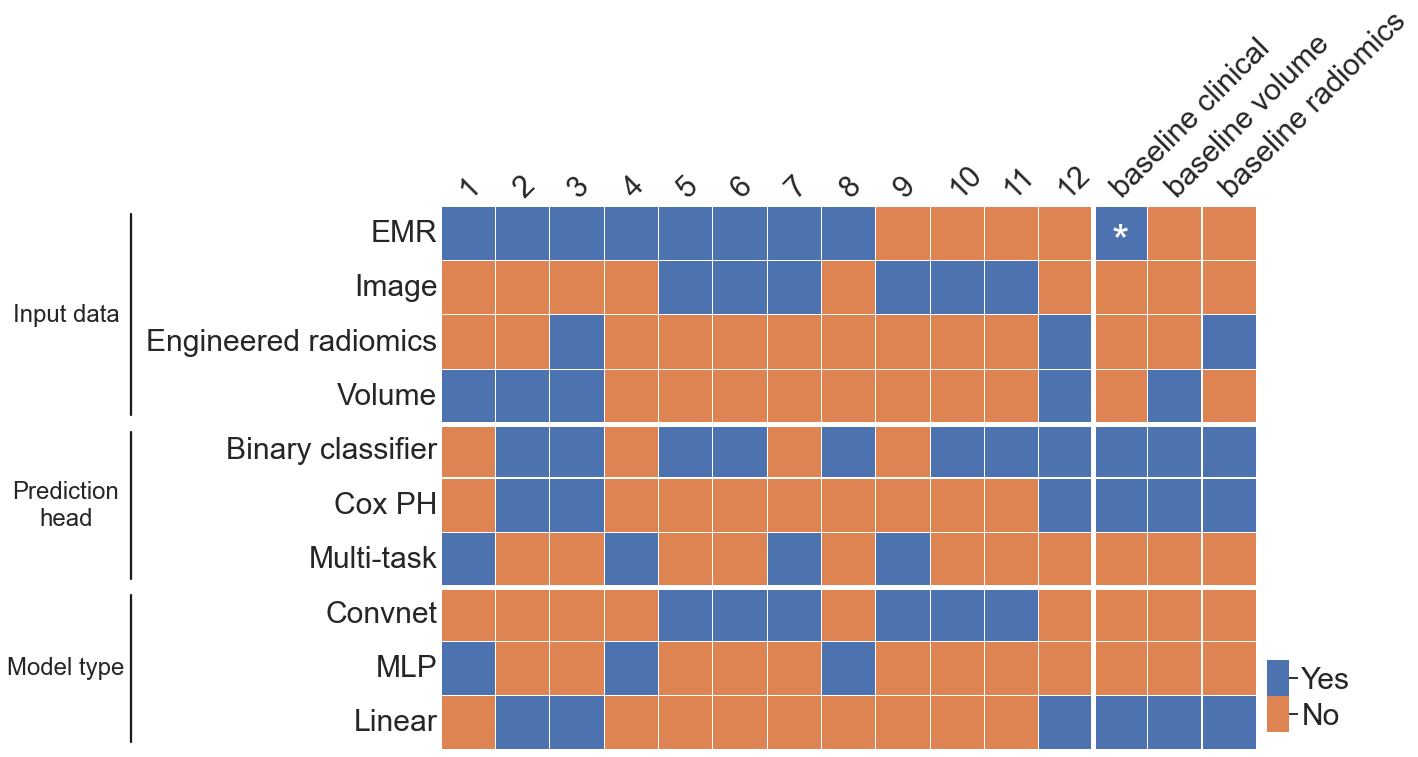

In [14]:
submission_feats = pd.read_csv('results/submission_features.csv', index_col='submission_id')
order = [
    'convnet', 'mlp', 'linear',
    'binary_classifier', 'proportional_hazards', 'multitask',
    'emr_data', 'image', 'engineered_features', 'volume',
]
fig, ax = plt.subplots()
cax = fig.add_axes([.9, .15, .02, .1])
ranking = challenge_results2['submission_id']
sns.heatmap(submission_feats.loc[ranking].drop(['model_type'], axis=1).fillna(0).T,
            ax=ax, cmap=ListedColormap(['C1', 'C0']), cbar=True, cbar_ax=cax, linewidths=.1,
            cbar_kws={'ticks': [.25, .75]}, square=True)
cax.set_yticklabels(['No', 'Yes'])
ax.set_xlabel('')
ax.set_yticklabels(['EMR', 'Image', 'Engineered radiomics', 'Volume', 'Binary classifier', 'Cox PH', 'Multi-task', 'Convnet', 'MLP', 'Linear'], rotation=0, va='center')
ax.set_xticks(np.arange(.25, 15.25))
ax.set_xticklabels(list(range(1, 13)) + ['baseline clinical', 'baseline volume', 'baseline radiomics'], rotation=45, ha='left')
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.xaxis.set_ticks_position('top')
ax.text(12.5, .7, '*', ha='center', va='center', c='w', fontsize=45)
ax.axhline(4, linewidth=5, c='w')
ax.axhline(7, linewidth=5, c='w')
ax.axvline(12, linewidth=5, c='w')

line_x = [-.38]*2
text_x = -.46
trans = ax.get_yaxis_transform()

ax.annotate('Input data', xy=(text_x, 2), xycoords=trans, ha='center', va='center', fontsize=24)
ax.plot(line_x, [.15, 3.85], color='k', transform=trans, clip_on=False)
ax.annotate('Prediction\nhead', xy=(text_x, 5.5), xycoords=trans, ha='center', va='center', fontsize=24)
ax.plot(line_x, [4.15, 6.85], color='k', transform=trans, clip_on=False)
ax.annotate('Model type', xy=(text_x, 8.5), xycoords=trans, ha='center', va='center', fontsize=24)
ax.plot(line_x, [7.15, 9.85], color='k', transform=trans, clip_on=False)

fig.savefig('figures/overview_heatmap.pdf', bbox_inches='tight')

## Figure 2bcd

In [15]:
def metrics_barplot(results, metric_name, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 10))
    order = ['combined', 'EMR', 'radiomics', 'baseline']
    colours = sns.color_palette('deep', len(order))
    group_sizes = [(results['kind'] == kind).sum() for kind in order]
    for i, kind in enumerate(order):
        g = results[results['kind'] == kind]
        for j, (_, r) in enumerate(g.sort_values(metric_name, ascending=False).iterrows()):
            rank = r['rank']
            if isinstance(rank, str):
                rot = 90
            else:
                rot = 0
            y = r[metric_name]
            yerr = np.abs(y - np.array([
                [r[f'{metric_name}_ci_low']],
                [r[f'{metric_name}_ci_high']]
            ]))
            x = i*10+j
            bar = ax.bar(x, y,
                         yerr=yerr, color=colours[i],
                         edgecolor=None)[0]
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + yerr[1] + .01, rank, ha='center', va='bottom', rotation=rot, fontsize=24)
    width = ax.patches[0].get_width()
    ax.set_xticks([i*10+s*width/2 for i, s in enumerate(group_sizes)])
    ax.set_xticklabels(order, ha='center')
    ax.set_xlabel('Submission type')
    ax.set_ylabel(metric_name)

    return ax

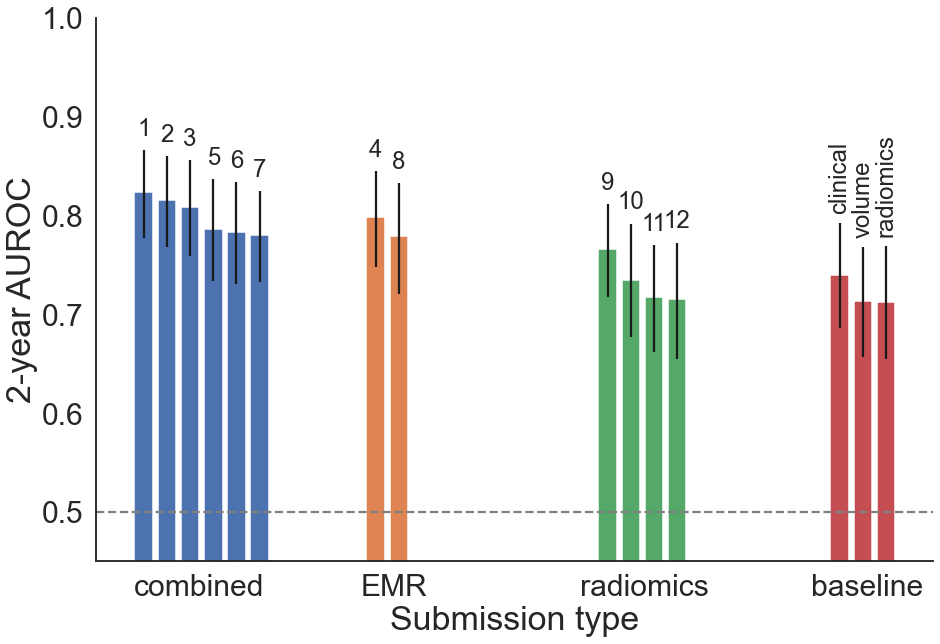

In [16]:
ax = metrics_barplot(challenge_results2, 'roc_auc')
ax.set_ylim(.45, 1)
ax.set_ylabel('2-year AUROC')
ax.axhline(.5, c='gray', linestyle='--')
sns.despine()
plt.savefig('figures/metrics_auroc.pdf', dpi=300, bbox_inches='tight')

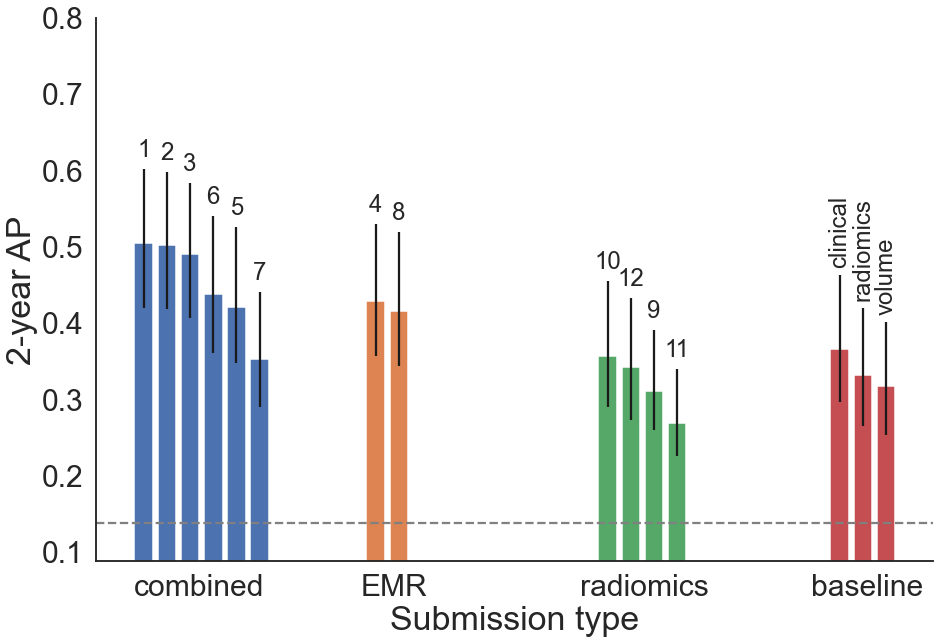

In [17]:
ax = metrics_barplot(challenge_results2, 'average_precision')
random = data['target_binary'].mean()
ax.set_ylim(random - .05, .8)
ax.set_ylabel('2-year AP')
ax.axhline(random, c='gray', linestyle='--')
sns.despine()
plt.savefig('figures/metrics_ap.pdf', dpi=300, bbox_inches='tight')

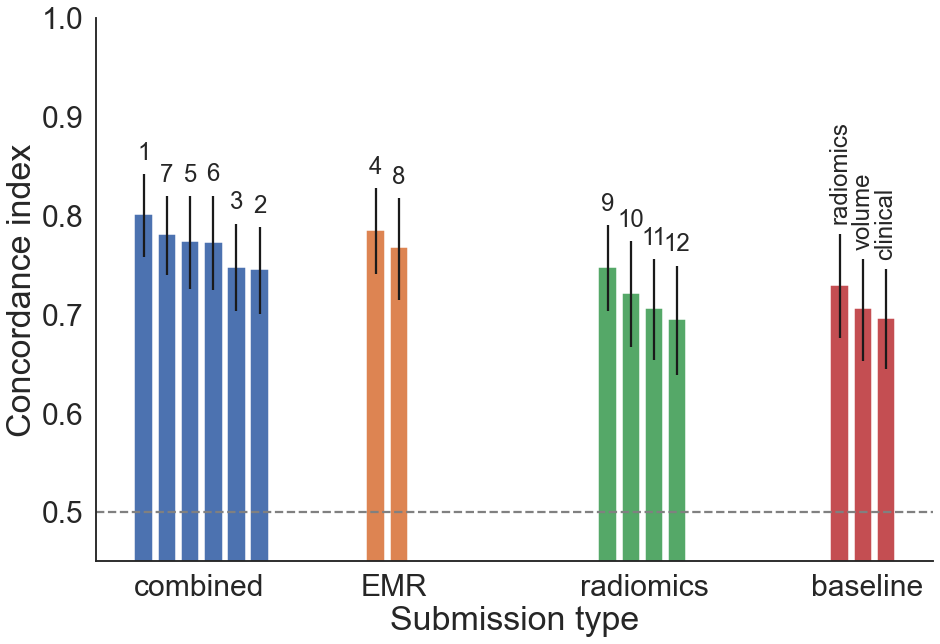

In [18]:
ax = metrics_barplot(challenge_results2, 'concordance_index')
ax.set_ylim(.45, 1)
ax.set_ylabel('Concordance index')
ax.axhline(.5, c='gray', linestyle='--')
sns.despine()
plt.savefig('figures/metrics_concordance.pdf', dpi=300, bbox_inches='tight')

## Figure 2efg and 5c

In [19]:
from lifelines.plotting import move_spines, remove_spines, remove_ticks

def add_at_risk_counts(*fitters, labels=None, ypos=-0.6, ax=None, **kwargs):
    '''
    Add counts showing how many individuals were at risk, censored, and observed, at each time point in
    survival/hazard plots.
    Tip: you may want to call ``plt.tight_layout()`` afterwards.
    Parameters
    ----------
    fitters:
      One or several fitters, for example KaplanMeierFitter, WeibullFitter,
      NelsonAalenFitter, etc...
    ax:
        a matplotlib axes
    labels:
        provide labels for the fitters, default is to use the provided fitter label. Set to
        False for no labels.
    ypos:
        increase to move the table down further.
    Returns
    --------
      ax:
        The axes which was used.
    Examples
    --------
    .. code:: python
        # First train some fitters and plot them
        fig = plt.figure()
        ax = plt.subplot(111)
        f1 = KaplanMeierFitter()
        f1.fit(data)
        f1.plot(ax=ax)
        f2 = KaplanMeierFitter()
        f2.fit(data)
        f2.plot(ax=ax)
        # There are equivalent
        add_at_risk_counts(f1, f2)
        add_at_risk_counts(f1, f2, ax=ax, fig=fig)
        # This overrides the labels
        add_at_risk_counts(f1, f2, labels=['fitter one', 'fitter two'])
        # This hides the labels
        add_at_risk_counts(f1, f2, labels=False)
    References
    -----------
     Morris TP, Jarvis CI, Cragg W, et al. Proposals on Kaplan–Meier plots in medical research and a survey of stakeholder views: KMunicate. BMJ Open 2019;9:e030215. doi:10.1136/bmjopen-2019-030215
    '''
    
    # adapted from https://github.com/CamDavidsonPilon/lifelines/blob/master/lifelines/plotting.py
    
    if ax is None:
        ax = plt.gca()

    fig = kwargs.pop('fig', None)
    if fig is None:
        fig = plt.gcf()

    rows_to_show = ['At risk', 'Censored']
    n_rows = len(fitters)

    # Create another axes where we can put size ticks
    ax2 = plt.twiny(ax=ax)
    # Move the ticks below existing axes
    # Appropriate length scaled for 6 inches. Adjust for figure size.
    ax_height = (ax.get_position().y1 - ax.get_position().y0) * fig.get_figheight()  # axis height
    ax2_ypos = ypos / ax_height
    move_spines(ax2, ['bottom'], [ax2_ypos])
    # Hide all fluff
    remove_spines(ax2, ['top', 'right', 'bottom', 'left'])
    # Set ticks and labels on bottom
    ax2.xaxis.tick_bottom()
    # Set limit
    min_time, max_time = ax.get_xlim()
    ax2.set_xlim(min_time, max_time)
    # Set ticks to kwarg or visible ticks
    xticks = kwargs.pop('xticks', None)
    if xticks is None:
        xticks = [xtick for xtick in ax.get_xticks() if min_time <= xtick <= max_time]
    ax2.set_xticks(xticks)
    # Remove ticks, need to do this AFTER moving the ticks
    remove_ticks(ax2, x=True, y=True)

    ticklabels = []

    for tick in ax2.get_xticks():
        lbl = ''

        # Get counts at tick
        counts = []
        for f in fitters:
            # this is a messy:
            # a) to align with R (and intuition), we do a subtraction off the at_risk column
            # b) we group by the tick intervals
            # c) we want to start at 0, so we give it it's own interval

            event_table_slice = (
                f.event_table.assign(at_risk=lambda x: x.at_risk - x.removed)
                .loc[:tick, ['at_risk', 'censored']]
                .agg({'at_risk': 'min', 'censored': 'sum'})
#                 .rename({'at_risk': 'At risk', 'censored': 'Censored'})
            )
            counts.append(event_table_slice.to_dict())
            
        # Create tick label
        lbl += ''
        for i, c in enumerate(counts):
            if i % n_rows == 0 and i > 0:
                lbl += '\n\n'
            s = '\n{at_risk} ({censored})'
            lbl += s.format(**c)

        ticklabels.append(lbl)

    ax2.set_xticklabels(ticklabels, ha='center', **kwargs)
    ax2.text(-.3, .11, 'At risk (censored)', va='top')
    return ax

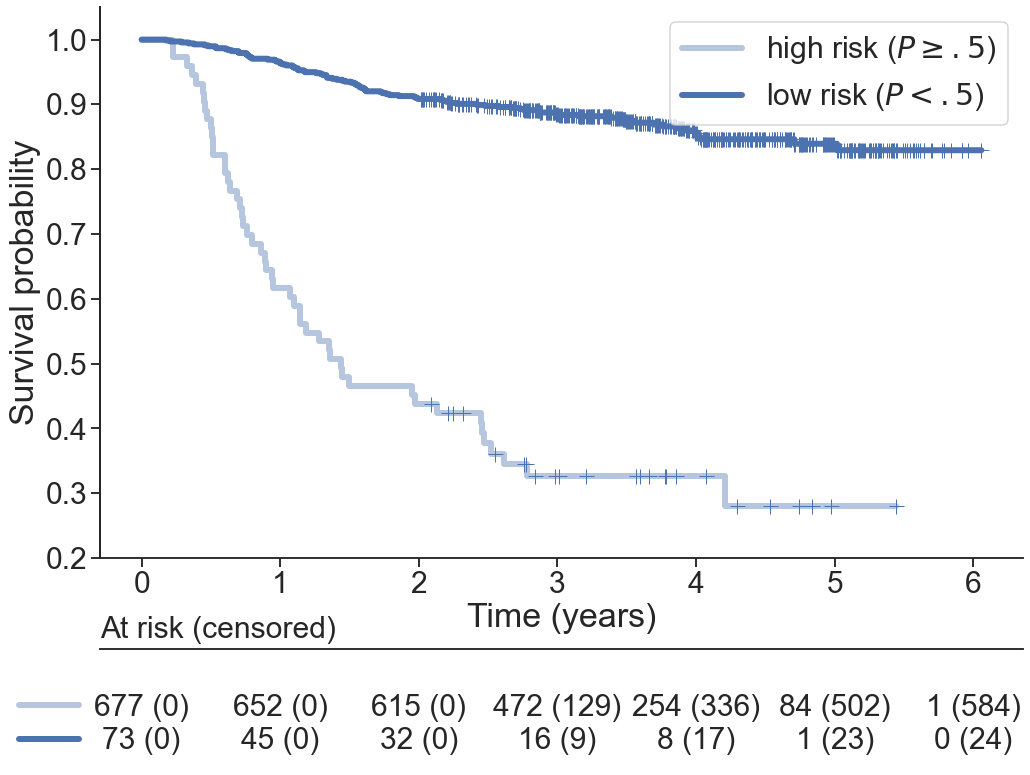

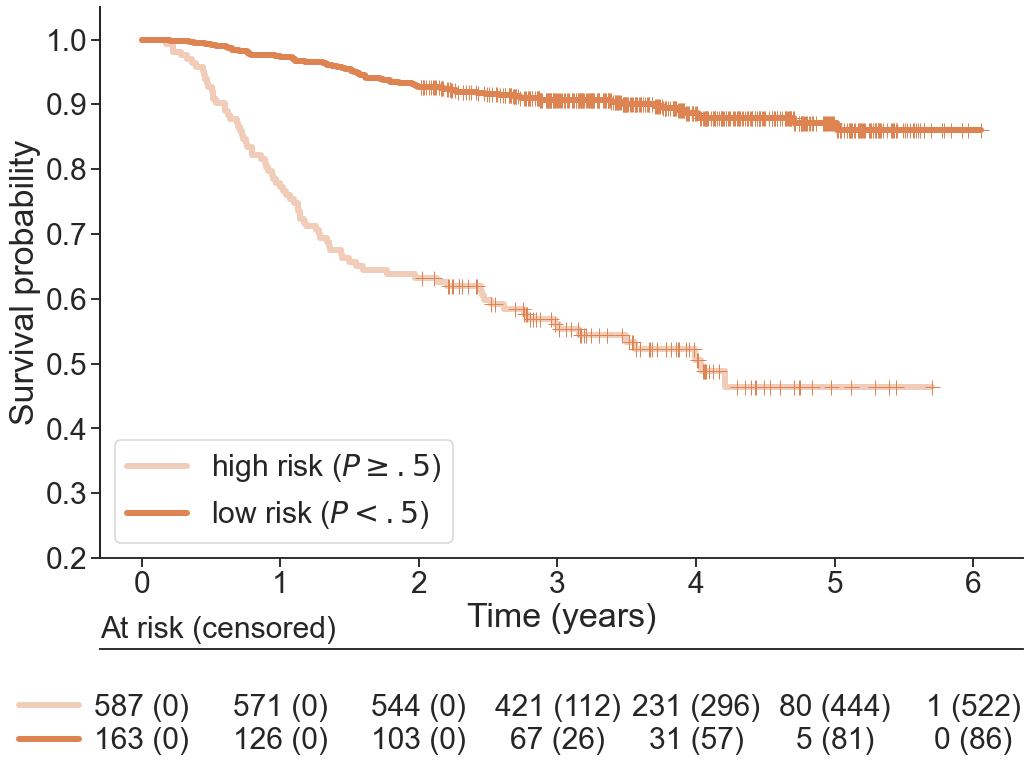

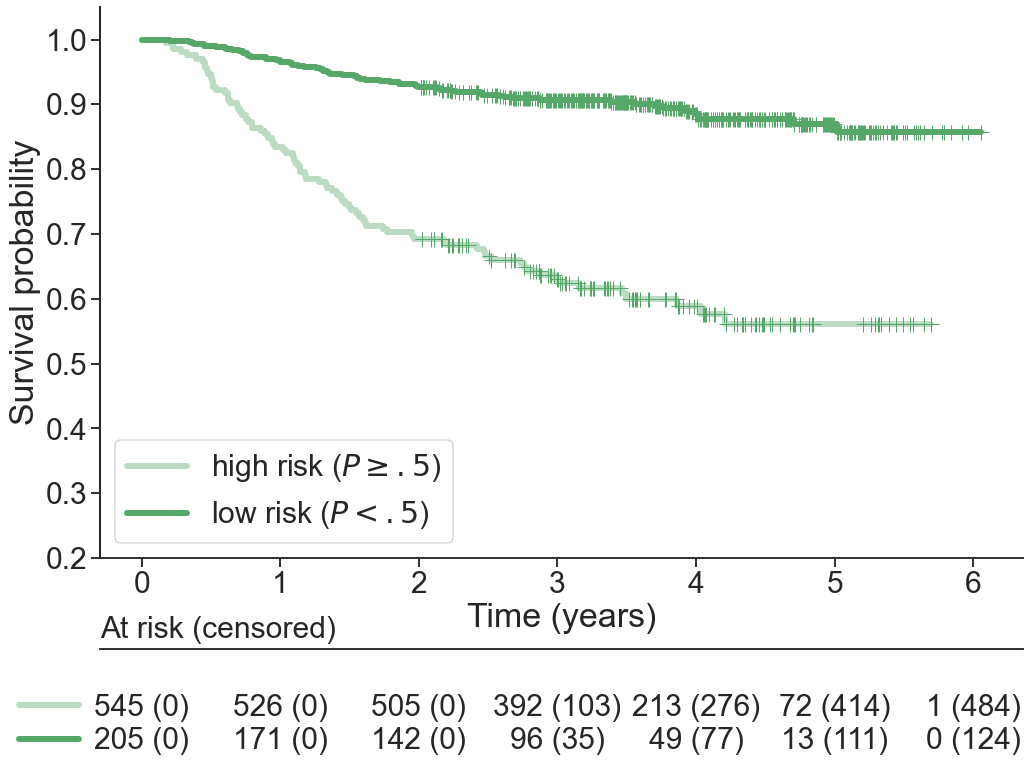

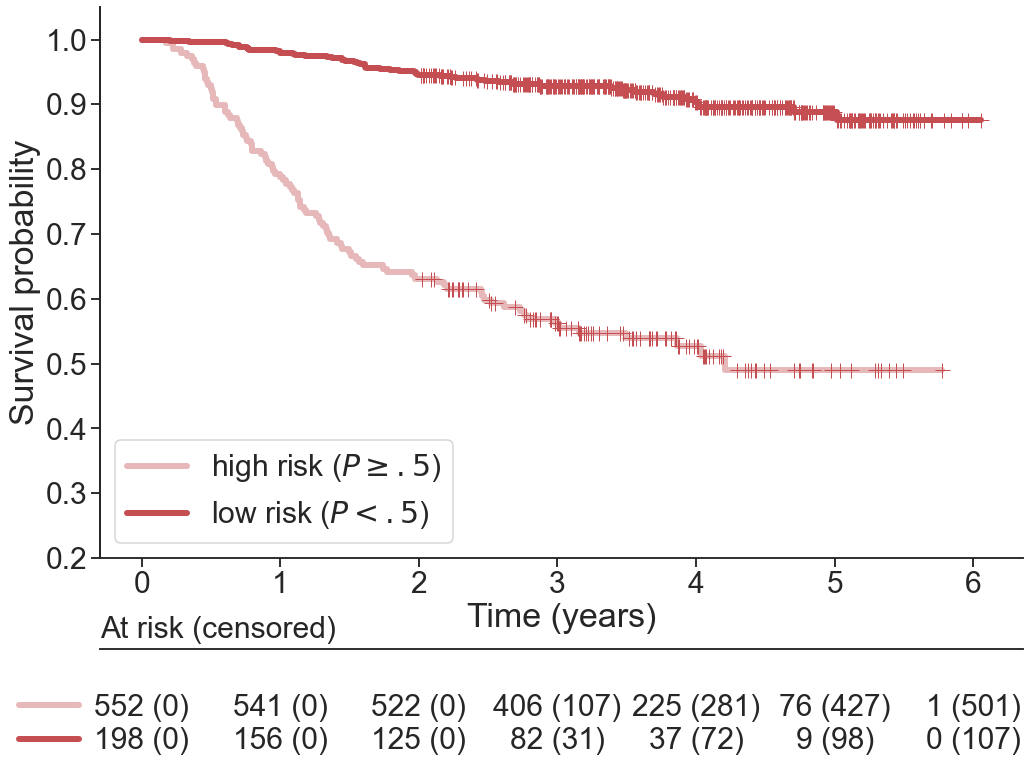

In [20]:
hazard_ratios = {}
with sns.axes_style('ticks'):
    for i, name in enumerate(['combined', 'EMR', 'radiomics', 'ensemble']):
        fig, ax = plt.subplots(figsize=(15, 12))
        pred = data[f'pred_{name}']
        data.loc[:, 'group'] = (pred - pred.min()) / (pred.max() - pred.min()) >= .5
        km1 = KaplanMeierFitter()
        km1.fit(data[data['group']]['survival_time'], event_observed=data[data['group']]['death'])
        ax = km1.plot(ax=ax, ci_show=False, legend=False, color=f'C{i}', linewidth=6, alpha=.4, label='high risk ($P \geq .5$)', show_censors=True, censor_styles={'ms': 15, 'marker': '+'})
        km2 = KaplanMeierFitter()
        km2.fit(data[~data['group']]['survival_time'], event_observed=data[~data['group']]['death'])
        cph = CoxPHFitter().fit(data[['survival_time', 'death', 'group']], 'survival_time', 'death', step_size=.5)
        hr, pval = cph.hazard_ratios_[0], cph.summary['p'][0]
        hazard_ratios[name] = {'hr': hr, 'pval': pval}
        ax = km2.plot(ax=ax, ci_show=False, legend=False, color=f'C{i}', linewidth=6, label='low risk ($P < .5$)', show_censors=True, censor_styles={'ms': 15, 'marker': '+'})
        data = data.drop('group', axis=1)
        ax.set_ylim(.2, 1.05)
        ax.set_xlabel('Time (years)')
        ax.set_ylabel('Survival probability')
        ypos = -1.5
        add_at_risk_counts(km2, km1, ax=ax, fig=fig, ypos=ypos)
        leg1 = ax.legend()
        ax.add_artist(leg1)
        ax_height = (ax.get_position().y1 - ax.get_position().y0) * fig.get_figheight()  # axis height
        leg2_ypos = ypos / ax_height
        ax.legend(leg1.legendHandles, [None, None], loc=(-.10, leg2_ypos-.215), frameon=False, labelspacing=.22)
        sns.despine()
        fig.tight_layout()
        fig.savefig(f'figures/{name}_km.pdf', dpi=300, bbox_inches='tight')

In [21]:
hazard_ratios

{'combined': {'hr': 8.635861530558417, 'pval': 2.6623735726959106e-33},
 'EMR': {'hr': 5.9564857920673875, 'pval': 1.0130744471835634e-25},
 'radiomics': {'hr': 4.493379007384389, 'pval': 1.4233215408424177e-18},
 'ensemble': {'hr': 7.039368817182607, 'pval': 3.0369075225103922e-28}}

## Figure 3ab

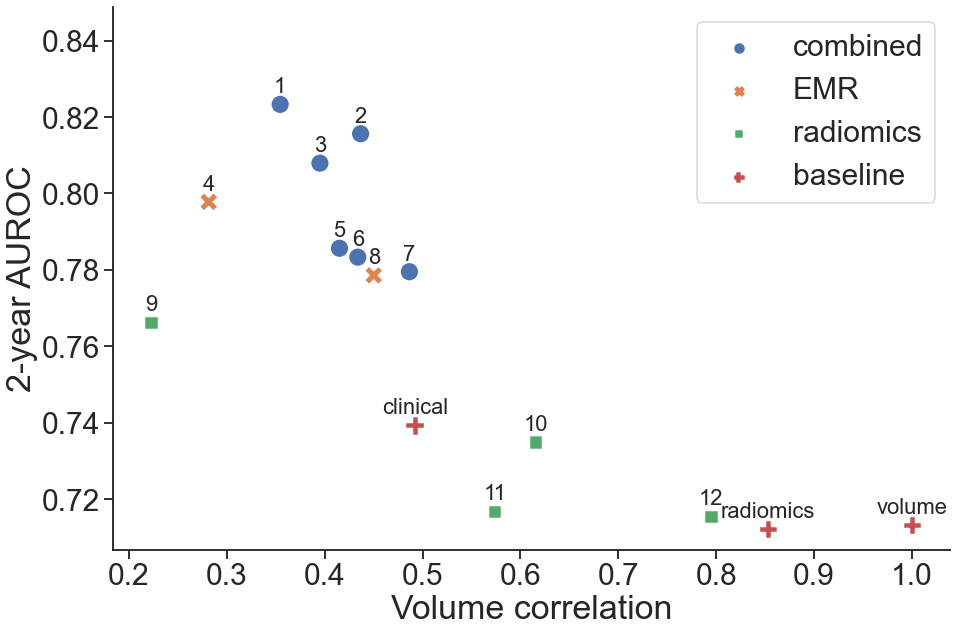

In [22]:
with sns.axes_style('ticks'):
    ax = sns.scatterplot(data=challenge_results2, x='volume_corr', y='roc_auc', hue='kind', style='kind', s=350)
    for i, r in challenge_results2.iterrows():
        ax.annotate(r['rank'], (r['volume_corr'], r['roc_auc']+.002), va='bottom', ha='center', fontsize=22)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + .02)
    ax.set_xlabel('Volume correlation')
    ax.set_ylabel('2-year AUROC')
    ax.legend(title=None)
    sns.despine()
plt.savefig('figures/volume_correlation_auroc.pdf', dpi=300, bbox_inches='tight')

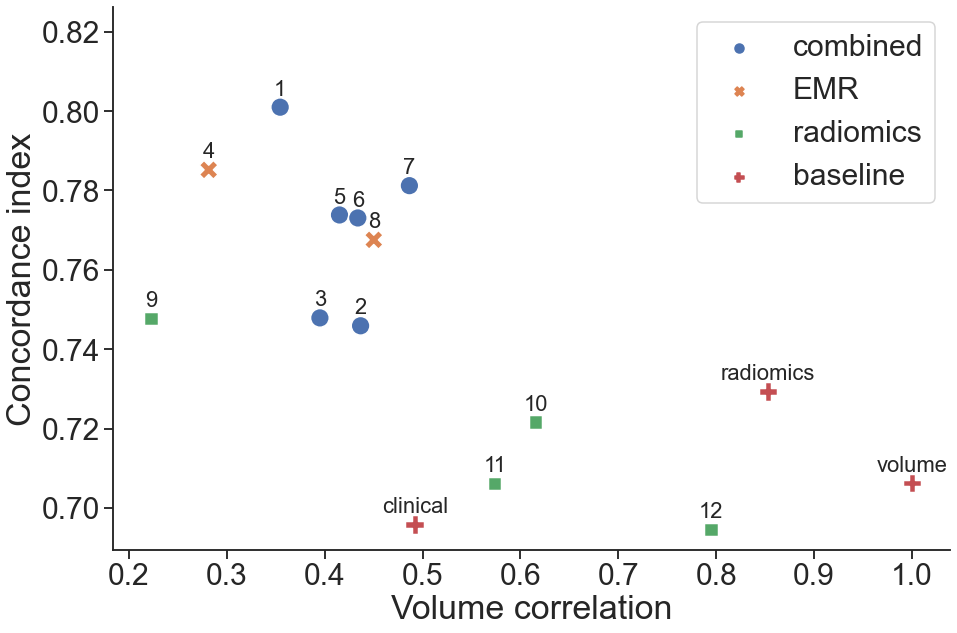

In [23]:
with sns.axes_style('ticks'):
    ax = sns.scatterplot(data=challenge_results2, x='volume_corr', y='concordance_index', hue='kind', style='kind', s=350)
    for i, r in challenge_results2.iterrows():
        ax.annotate(r['rank'], (r['volume_corr'], r['concordance_index']+.002), va='bottom', ha='center', fontsize=22)
    ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1] + .02)
    ax.set_xlabel('Volume correlation')
    ax.set_ylabel('Concordance index')
    ax.legend(title=None)
    sns.despine()
plt.savefig('figures/volume_correlation_concordance.pdf', dpi=300, bbox_inches='tight')

## Figure 4b

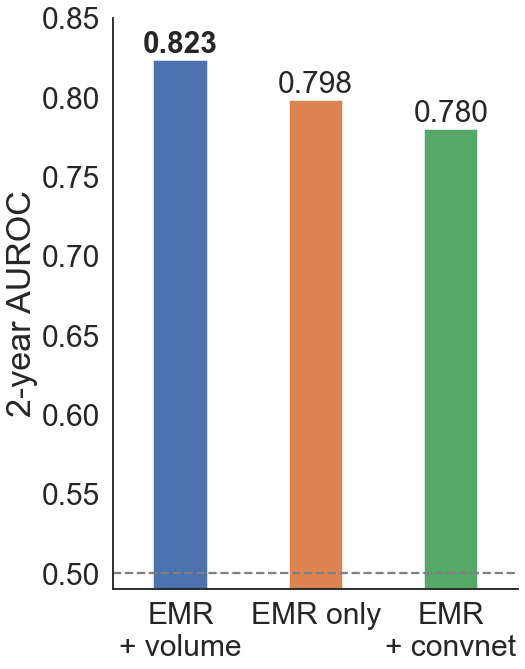

In [24]:
ids = ['5e515f3', 'a4c8caa', 'c22638c']
fig, ax = plt.subplots(figsize=(8, 10))
ax.set_xlim(-.5, 2.5)
ax.set_ylim(.49, .85)

for j, (_, r) in enumerate(challenge_results[challenge_results['submission_id'].isin(ids)].iterrows()):
    auc = r['roc_auc']
    ax.bar(j, auc, width=.4)
    ax.text(j, auc + .001, f'{auc:.3f}', ha='center', va='bottom', weight='bold' if j == 0 else 'normal')
ax.set_ylabel('2-year AUROC')
ax.set_xticks(np.arange(3))
labels = ['EMR\n+ volume', 'EMR only', 'EMR\n+ convnet']
ax.set_xticklabels(labels)

ax.set_ylabel('2-year AUROC')
ax.axhline(.5, c='gray', linestyle='--')
sns.despine()
fig.tight_layout()
fig.savefig('figures/best_submission_metrics.pdf')

## Figure 5a

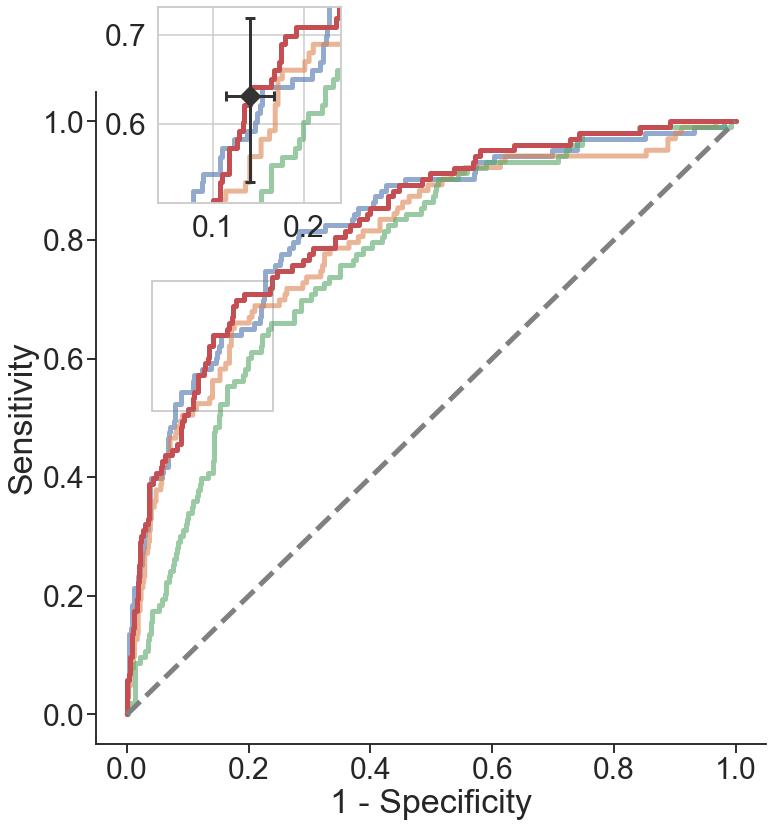

In [25]:
ensemble_results = results.query('submission_id == "ensemble"')
best_fpr, best_tpr = 1 - ensemble_results['best_specificity'].iloc[0], ensemble_results['best_sensitivity'].iloc[0]

with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(12, 12))
    with sns.axes_style('whitegrid'):
        ins_ax = zoomed_inset_axes(ax, 1.5, loc='upper left', bbox_to_anchor=(155,860))
    for kind in ['combined', 'EMR', 'radiomics', 'ensemble']:
        fpr, tpr, _ = roc_curve(data['target_binary'], data[f'pred_{kind}'])
        alpha = 1 if kind == 'ensemble' else .6
        ax.plot(fpr, tpr, label=kind, linewidth=5, alpha=alpha)
        ins_ax.plot(fpr, tpr, linewidth=5, alpha=alpha)
    ax.plot((0,1), (0,1), c='gray', linestyle='--', linewidth=5)
    ax.set_xlabel('1 - Specificity')
    ax.set_ylabel('Sensitivity')
    sns.despine(ax=ax)

    ins_ax.set_xlim(best_fpr-.1, best_fpr+.1)
    ins_ax.set_ylim(best_tpr-.12, best_tpr+.1)
    ins_ax.scatter(best_fpr, best_tpr, c='#333333', marker='D', s=200, zorder=100)
    ax.indicate_inset_zoom(ins_ax)
    
    xerr = np.abs(best_fpr - np.array([
        1 - ensemble_results['best_specificity_ci_low'],
        1 - ensemble_results['best_specificity_ci_high']
    ]))
    yerr = np.abs(best_tpr - np.array([
        ensemble_results['best_sensitivity_ci_low'],
        ensemble_results['best_sensitivity_ci_high']
    ]))
    ins_ax.errorbar(best_fpr, best_tpr, xerr=xerr, yerr=yerr, c='#333333', capsize=5, capthick=3, linewidth=3, zorder=100)
plt.savefig('figures/ensemble_roc.pdf', dpi=300, bbox_inches='tight')

## Figure 5b

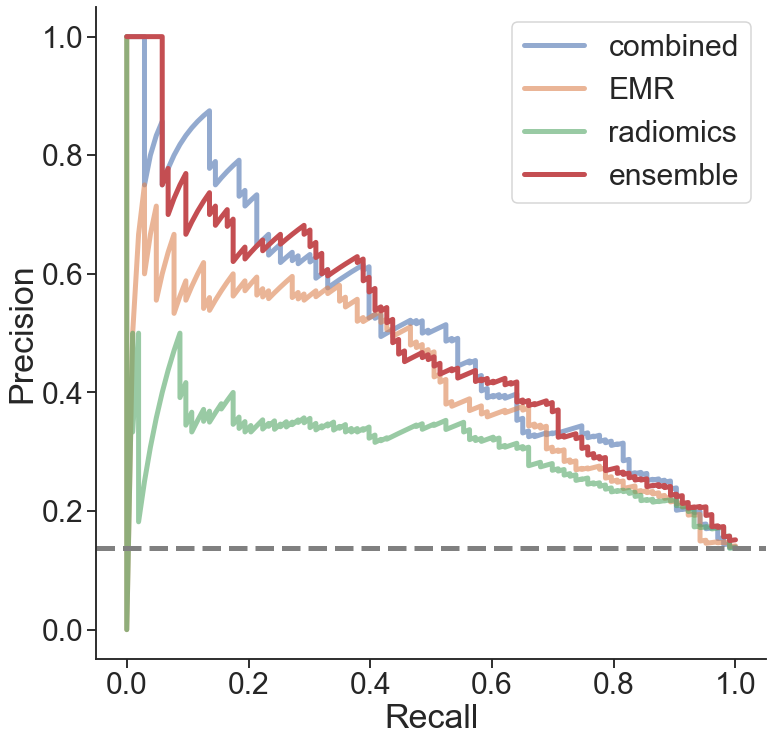

In [26]:
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(figsize=(12, 12))
    for name in ['combined', 'EMR', 'radiomics', 'ensemble']:
        prec, rec, _ = precision_recall_curve(data['target_binary'], data[f'pred_{name}'])
        alpha = 1 if name == 'ensemble' else .6
        ax.plot(rec, prec, label=name, linewidth=5, alpha=alpha)
    ax.axhline(data['target_binary'].mean(), c='gray', linestyle='--', linewidth=5)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend()
    sns.despine()
plt.savefig('figures/ensemble_pr.pdf', dpi=300, bbox_inches='tight')

## Figure 5d

In [27]:
challenge_predictions = [p for p in all_predictions if p['group'] == 'challenge']
sorted_predictions = sorted(challenge_predictions, key=lambda x: challenge_results.loc[challenge_results['submission_id'] == x['submission_id'], 'rank'].item())
target = data['target_binary'].sort_index()
ensemble_results = []
partial_ensemble_predictions = pd.Series(np.zeros(len(target)), name='binary', index=target.index)
for i, p in enumerate(sorted_predictions):
    partial_ensemble_predictions += p['predictions']['binary']
    ensemble_results.append({
        'rank': i+1,
        'roc_auc': roc_auc_score(target, partial_ensemble_predictions / (i + 1))
    })
ensemble_results = pd.DataFrame(ensemble_results).sort_values('rank')

In [28]:
from scipy.stats import spearmanr

best_pred = [p['predictions'] for p in all_predictions if p['submission_id'] == challenge_results.loc[challenge_results['rank'] == 1, 'submission_id'][0]][0]
best_pred_corrs = []
volume_corrs = []
for _, r in challenge_results.sort_values('rank').iterrows():
    submission_id = r['submission_id']
    cur_predictions = [p['predictions'] for p in all_predictions if p['submission_id'] == submission_id][0]
    corr, _ = spearmanr(best_pred['binary'], cur_predictions.loc[best_pred.index, 'binary'])
    best_pred_corrs.append(corr)
    volume_corrs.append(r['volume_corr'])

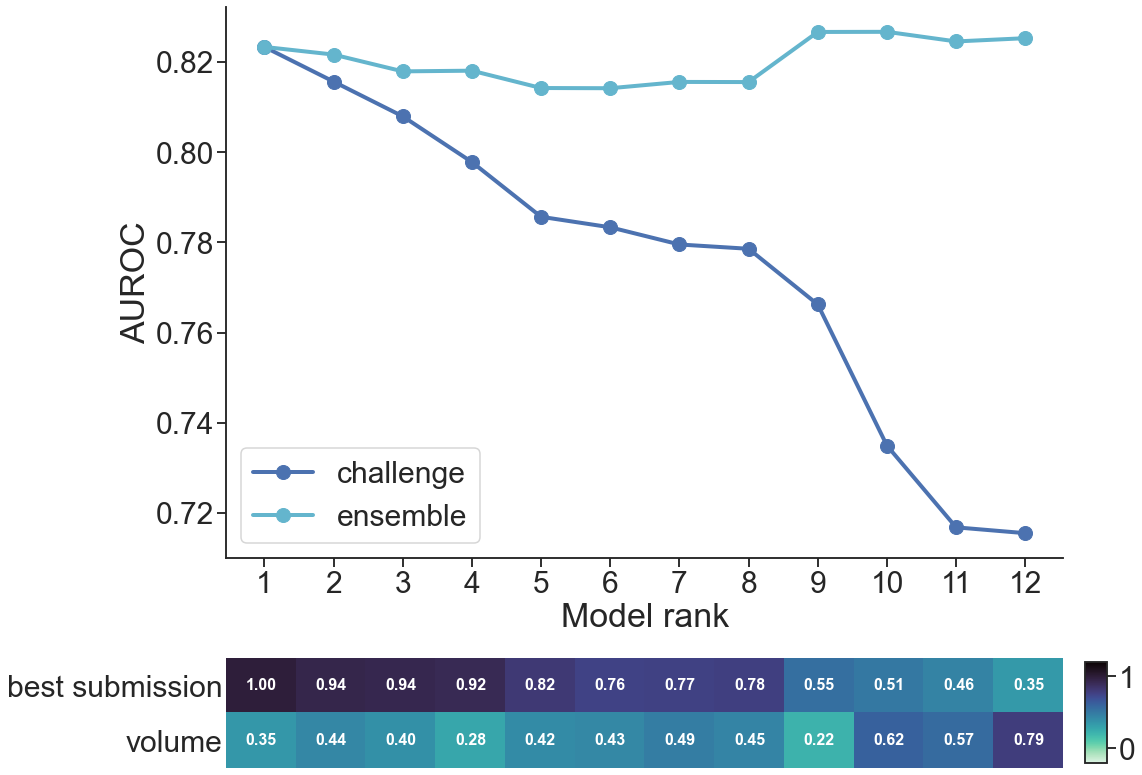

In [29]:
cmap = {x: f'C{i}' for i, x in enumerate(['combined', 'clinical', 'radiomics'])}
colours = challenge_results['kind'].map(cmap)
with sns.axes_style('ticks'):
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1], 'hspace': .3}, figsize=(15, 14))
    ax[0].plot(challenge_results['rank'], challenge_results['roc_auc'], lw=4, label='challenge', marker='o', markersize=14)
    ax[0].plot(ensemble_results['rank'], ensemble_results['roc_auc'], lw=4, label='ensemble', c='C9', marker='o', markersize=14)
    ax[0].set_xticks(range(1, 13))
    ax[0].set_xticklabels(list(range(1, 13)))
    ax[0].set_xlabel('Model rank')
    ax[0].set_ylabel('AUROC')
    sns.despine()
    ax[0].legend()
    im = ax[1].imshow([best_pred_corrs, volume_corrs], aspect='auto', vmin=-.2, vmax=1.2, cmap='mako_r', extent=(.5, 12.5, 0, 2))
    ax[1].set_xticks(np.arange(.5, 12.5))
    ax[1].set_xticklabels([])
    ax[1].xaxis.set_visible(False)
    for spine in ax[1].spines.values():
        spine.set_visible(False)
    ax[1].set_yticks([.5, 1.5])
    ax[1].set_yticklabels(['volume', 'best submission'])
    ax[1].yaxis.set_tick_params(length=0)
    for i, (c1, c2) in enumerate(zip(best_pred_corrs, volume_corrs)):
        ax[1].text(i+1, 1.5, f'{c1:.2f}', ha='center', va='center', fontsize=16, c='w', weight='bold')
        ax[1].text(i+1, .5, f'{c2:.2f}', ha='center', va='center', fontsize=16, c='w', weight='bold')
    cax = fig.add_axes([0.92,.13,0.02,0.1])
    fig.colorbar(im, cax=cax)
plt.savefig('figures/ensemble_models.pdf', dpi=300, bbox_inches='tight')

## Figure 5e

In [30]:
results.loc[results['kind'] == 'baseline', 'kind'] = results.loc[results['kind'] == 'baseline', 'submission_id']
table2 = results.groupby(['group', 'kind']).max('roc_auc').sort_values('roc_auc', ascending=False)
table2[['roc_auc', 'average_precision', 'concordance_index']] = table2[['roc_auc', 'average_precision', 'concordance_index']].apply(format_metric_ci, df=table2)
table2 = table2.rename(columns={'roc_auc': 'AUROC', 'average_precision': 'AP', 'concordance_index': 'C-index'}).reset_index()
table2.loc[table2['group'] == 'baseline', 'kind'] = 'baseline-' + table2.loc[table2['group'] == 'baseline', 'kind']

In [31]:
table2

,group,kind,AUROC,roc_auc_pval,roc_auc_ci_low,roc_auc_ci_high,AP,average_precision_pval,average_precision_ci_low,average_precision_ci_high,...,volume_corr,volume_corr_pval,C-index,concordance_index_pval,concordance_index_ci_low,concordance_index_ci_high,integrated_brier_score,integrated_brier_score_pval,integrated_brier_score_ci_low,integrated_brier_score_ci_high
0,ensemble,ensemble,0.825 [0.781--0.866],0.0001,0.780510,0.866195,0.495 [0.414--0.591],0.0001,0.413920,0.590640,...,0.524538,3.009914e-54,0.808 [0.770--0.843],0.0001,0.770255,0.843196,0.044588,1.0,0.042117,0.047145
1,challenge,combined,0.823 [0.777--0.866],0.0001,0.776578,0.866043,0.505 [0.420--0.602],0.0001,0.419630,0.601793,...,0.486522,1.264351e-23,0.801 [0.757--0.842],0.0001,0.757402,0.841709,0.087371,1.0,0.081821,0.092972
2,challenge,EMR,0.798 [0.748--0.845],0.0001,0.747759,0.844938,0.429 [0.356--0.530],0.0001,0.356045,0.529756,...,0.450117,4.022232e-15,0.785 [0.740--0.827],0.0001,0.740323,0.827060,0.043808,1.0,0.040748,0.046830
3,challenge,radiomics,0.766 [0.718--0.811],0.0001,0.717725,0.810852,0.357 [0.289--0.455],0.0001,0.288954,0.454783,...,0.794749,7.279301e-10,0.748 [0.703--0.790],0.0001,0.703173,0.789674,0.060796,1.0,0.055743,0.065717
4,baseline,baseline-clinical,0.739 [0.686--0.792],0.0001,0.685891,0.792264,0.366 [0.295--0.463],0.0001,0.295351,0.462547,...,0.491932,5.860917e-47,0.696 [0.644--0.746],0.0001,0.644043,0.745624,0.048510,1.0,0.045546,0.051304
5,baseline,baseline-volume,0.713 [0.657--0.767],0.0001,0.656862,0.767472,0.317 [0.252--0.401],0.0001,0.252402,0.401346,...,1.000000,0.000000e+00,0.706 [0.653--0.756],0.0001,0.652625,0.755579,0.045746,1.0,0.042786,0.048507
6,baseline,baseline-radiomics,0.712 [0.655--0.769],0.0001,0.654612,0.768791,0.331 [0.264--0.420],0.0001,0.264139,0.419545,...,0.852948,2.233331e-213,0.729 [0.675--0.781],0.0001,0.675316,0.781344,0.048521,1.0,0.045605,0.051288


In [32]:
table2.to_latex('figures/table2.tex', index=False, columns=['kind', 'AUROC', 'AP', 'C-index'])

In [33]:
thresholds = np.arange(0.1, 1, .1)
dfs = []
for name in ['combined', 'EMR', 'radiomics', 'ensemble']:
    df = pd.DataFrame((data[f'pred_{name}'].values > thresholds[:, np.newaxis]).T,
                      index=data.index,
                      columns=thresholds)
    df = pd.melt(df, value_name='prediction', var_name='threshold')
    df['name'] = name
    dfs.append(df)
dfs = pd.concat(dfs, ignore_index=True)

## Supplementary figure 2

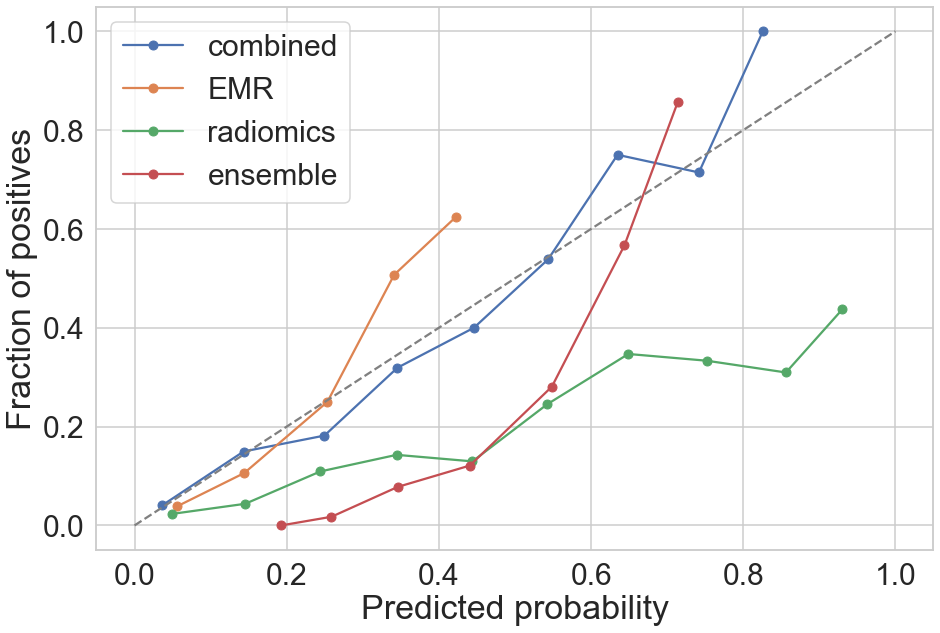

In [34]:
from sklearn.calibration import calibration_curve

with sns.axes_style('whitegrid'):
    fig, ax = plt.subplots()
    for name in ['combined', 'EMR', 'radiomics', 'ensemble']:
        frac_positives, pred_prob = calibration_curve(data['target_binary'], data[f'pred_{name}'], n_bins=10)
        ax.plot(pred_prob, frac_positives, marker='o', label=name)
    ax.plot((0, 1), (0, 1), c='grey', linestyle='--')
    ax.set_xlabel('Predicted probability')
    ax.set_ylabel('Fraction of positives')
    ax.legend()
plt.savefig('figures/calibration_curves.pdf', dpi=300, bbox_inches='tight')

## Ensemble risk deciles

In [35]:
data['pred_decile'] = pd.qcut(data['pred_ensemble'], 10)

In [36]:
(data.groupby('pred_decile')['cancer_death'].sum() / data['cancer_death'].sum())[::-1].cumsum()

pred_decile
(0.592, 0.725]    0.372549
(0.506, 0.592]    0.578431
(0.427, 0.506]    0.745098
(0.392, 0.427]    0.784314
(0.355, 0.392]    0.862745
(0.328, 0.355]    0.921569
(0.297, 0.328]    0.950980
(0.272, 0.297]    0.960784
(0.245, 0.272]    0.990196
(0.186, 0.245]    1.000000
Name: cancer_death, dtype: float64

## Ensemble predictions adjusted for disease site

In [37]:
data = pd.get_dummies(data, columns=['Disease Site'], drop_first=True)

In [38]:
cols = ['survival_time', 'death', 'pred_ensemble'] + [c for c in data.columns if 'Disease Site' in c]
cph = CoxPHFitter(penalizer=.0).fit(data[cols], 'survival_time', 'death')
print(cph.summary['p'][0])
cph.print_summary()

8.312480267636958e-33


<lifelines.CoxPHFitter: fitted with 750 total observations, 609 right-censored observations>
             duration col = 'survival_time'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 750
number of events observed = 141
   partial log-likelihood = -806.96
         time fit was run = 2021-01-07 16:06:24 UTC

---
                                 coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                              
pred_ensemble                    8.74    6249.88       0.73             7.30            10.18              1486.70             26273.61
Disease Site_hypopharynx        -1.25       0.29       0.48            -2.19            -0.31                 0.11                 0.73
Disease Site_larynx             -1.08       0.34       0.43            -1.93            -0.24                 0.15                 0.79
Disease Site_lip & oral cavity  -0.80       0.45       0.56            -1.90             0.29                 0.15                 1.34
Disease Site_nasal cavity       -1.79       0.17       0.63            -3.03            -0.56                 0.05                 0.57
Disease Site_nasopharynx        -1.27       0.28       0.54            -2.32            -0.21                 0.10                 0.81
Disease Site_oropharynx         -1.20       0.30       0.40            -1.99            -0.41                 0.14                 0.67
Disease Site_paranasal sinus    -1.51       0.22       0.59            -2.67            -0.35                 0.07                 0.70
Disease Site_salivary glands    -1.05       0.35       1.07            -3.15             1.05                 0.04                 2.87

                                   z      p   -log2(p)
covariate                                             
pred_ensemble                  11.93 <0.005     106.57
Disease Site_hypopharynx       -2.61   0.01       6.79
Disease Site_larynx            -2.51   0.01       6.36
Disease Site_lip & oral cavity -1.44   0.15       2.73
Disease Site_nasal cavity      -2.85 <0.005       7.82
Disease Site_nasopharynx       -2.36   0.02       5.76
Disease Site_oropharynx        -2.97 <0.005       8.39
Disease Site_paranasal sinus   -2.56   0.01       6.58
Disease Site_salivary glands   -0.98   0.33       1.61
---
Concordance = 0.81
Partial AIC = 1631.92
log-likelihood ratio test = 193.66 on 9 df
-log2(p) of ll-ratio test = 120.09

## Agreement between metrics

In [39]:
challenge_results2[['roc_auc', 'average_precision', 'concordance_index']].corr()['roc_auc'].sort_values()

concordance_index    0.824006
average_precision    0.879178
roc_auc              1.000000
Name: roc_auc, dtype: float64